In [25]:
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import scipy.stats as stats
import seaborn as sns
import pandas as pd 
import numpy as np
import random
import itertools


from statistics import mean, stdev
from patsy import dmatrix
from math import sqrt

sns.set_theme(context="talk")
pal = sns.color_palette()

### functions

In [230]:
def remove_outlier(df, index):
    Q1 = df[index].quantile(0.25)
    Q3 = df[index].quantile(0.75)

    IQR = Q3 - Q1

    filter = (df[index] >= Q1 - 2*IQR) &  (df[index] <= Q3 + 2*IQR)
    outlier =  (df[index] <= Q1 - 2*IQR) |  (df[index] >= Q3 + 2*IQR)

    return df.loc[filter], df.loc[outlier]

def clean_dataframe(df, index):
  df = df[(df != 0).all(1)]
  df = df.dropna()
  
  df_inliers, df_outlier = remove_outlier(df, index)

  return df_inliers, df_outlier

def cohens_d(c0, c1):
  std_diff = sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2)
  return (mean(c0) - mean(c1)) / std_diff


def hue_regplot(data, x, y, hue, palette=None, legend=False, **kwargs):
    
  regplots = []
  levels = data[hue].unique()
  pal = sns.color_palette("husl", n_colors=len(levels))

  i = 0
  if legend:
    for key in levels:
      regplots.append(sns.regplot(x=x, y=y, data=data[data[hue] == key], color=pal[i], label= key))
      # plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left")
      i +=1
  else:
    for key in levels:
      regplots.append(sns.regplot(x=x, y=y, data=data[data[hue] == key], color=pal[i]))
      i +=1

  return regplots
  
def bootstrap(df, model, n_boot, n_sample_age, knot, formula):

  df_age = df.loc[ (df['Age'] >= knot -3) & (df['Age'] <= knot+3) ]
  list_knots = np.unique(df_age['Age'])


  x = np.zeros((n_boot,))
  bs_replicates = np.zeros((n_boot,n_sample_age))
  x = np.zeros((n_boot,n_sample_age))

  ## apply bootstrapping on age and predict regression spline
  for i in range(n_boot):
      k = random.choice(list_knots)
      df_sampled = df.sample(n=n_sample_age)
      
      bs_sample = df_sampled['Age']
      bs_sample = sorted(bs_sample)

      df_sampled.sort_values(by=['Age'])

      # print(df_sampled['Age'].min())
      x[i,:] = bs_sample
      fit = model.predict(dmatrix(formula,{"Age": bs_sample, "k":k, "indicator": df_sampled['Indicator']},return_type = 'dataframe' ))

      bs_replicates[i,:] = fit
  return bs_replicates, x

In [41]:
def model_1(df, x, y, covariates, knots, threshold=0.005):
  k = [1,2,3]
  ### cubic model -full model -- def models(x,y, knots)
  # formula = "bs(Age, knots = 77, degree=3) + Cov"
  # cubic_x1 = dmatrix(formula, {"Age": df[x], 'Cov':df[covariates]}, return_type = 'dataframe')

  cubic_x1=dmatrix("bs(Age, knots=(77,), degree=3)",{"Age": df[x]},return_type = 'dataframe' )
  cubic_model = sm.GLM(df[y], cubic_x1).fit()
  
  ### linear regression to compare -- reduced model
  covariates.insert(0,x)
  reg_x1 = df[covariates]
  reg_x1 = sm.add_constant(reg_x1)
  regression_model = sm.OLS(df[y], reg_x1).fit()
  
  ### polyniomal regression order 3 to compare -- reduced model
  # age_x = df[ ['Age']]
  # age_x.insert(1, "Age2",  np.power(age_x['Age'], 2))
  # age_x.insert(2, "Age3",  np.power(age_x['Age'], 3))
  # age_x = sm.add_constant(age_x)
  # polynomial_model = sm.OLS(df[y], age_x).fit()




  ### likelihood ratio test --- calculate likelihood ratio Chi-Squared test statistic ## difference of log-likelihood
  LR_statistic = -2*(regression_model.llf-cubic_model.llf)

  #calculate p-value of test statistic using 2 degrees of freedom
  p_val = stats.chi2.sf(LR_statistic, 2)
  char = '<' if p_val < 0.005 else '>'
  test_result = "likelihood ratio test: ({:.4f}) {} {}".format(p_val, char, 0.005)



  return cubic_model, regression_model, test_result


def plot_two_models(df, x, y, covariates, m_cub, m_reg, knots, t):
  tmp = df.sort_values('Age')
  df_lim = tmp
  
  sns.scatterplot(x=x, y=y, data=df_lim, alpha=0.4)

  formula = "bs(Age, knots = 77, degree=3) + Cov"


  fit_cubic = m_cub.predict(dmatrix("bs(Age, knots=(77,), degree=3)",{"Age": df_lim[x]},return_type = 'dataframe' ))

  ### likelihood ratio test --- calculate likelihood ratio Chi-Squared test statistic ## difference of log-likelihood
  LR_statistic = -2*(m_reg.llf-m_cub.llf)

  #calculate p-value of test statistic using 2 degrees of freedom
  p_val = stats.chi2.sf(LR_statistic, 2)
  char = '<' if p_val < 0.005 else '>'
  test_result = "{} - likelihood ratio test: ({:.4f}) {} {}".format(t, p_val, char, 0.005)

  res = pd.DataFrame({'x':df_lim[x], 'y':fit_cubic})

  sns.lineplot(x='x', y='y', data=res, label=test_result, ci=80)

  plt.xlabel(x)
  plt.ylabel(y)
  plt.legend()

In [216]:
def model_2(df, x, y, covariates, knots, threshold=0.005):

  data_dict = {"Age": df[x], "indicator": df['Indicator'], 'Cov':df[covariates]}

  ### cubic model -full model -- def models(x,y, knots)
  cubic_x1=dmatrix("bs(Age, knots=(77,), degree=3)",{"Age": df[x]},return_type = 'dataframe' )


  x1 = dmatrix("indicator*bs(Age, knots = (77,), degree=3)", data_dict, return_type = 'dataframe')
  m1 = sm.GLM(df[y], x1).fit()

  ### cubic model without interaction -- reduced model
  x2 = dmatrix("indicator+bs(Age, knots = (77,), degree=3)  + Cov", data_dict, return_type = 'dataframe')
  m2 = sm.GLM(df[y], x2).fit()



  ### likelihood ratio test -- calculate likelihood ratio Chi-Squared test statistic ## difference of log-likelihood
  LR_statistic = -2*(m1.llf-m2.llf)

  ## calculate p-value of test statistic using 2 degrees of freedom
  p_val = stats.chi2.sf(LR_statistic, 2)
  char = '<' if p_val < 0.005 else '>'
  test_result = "p ({:.4f}) {} {}".format( p_val, char, 0.005)

  return m1, m2, test_result


def plot_interaction_models(df, x, y, covariates, m1, m2, knots):
  tmp = df.sample(50)
  tmp = tmp.sort_values('Age')
  df_lim = tmp
  data_dict = {"Age": df_lim[x], "indicator": df_lim['Indicator'], 'Cov':df_lim[covariates]}


  sns.scatterplot(x=x, y=y, data=df_lim, hue='Indicator', alpha=0.4)
  
  ## interaction model
  fit1 = m1.predict(dmatrix("indicator*bs(Age, knots =(77,), degree=3) + Cov", data_dict, return_type = 'dataframe'))
  
  ## no interaction model
  fit2 = m2.predict(dmatrix("indicator+bs(Age, knots = (77,), degree=3)  + Cov", data_dict, return_type = 'dataframe'))


  # plt.plot(df_lim[x], fit1, linewidth = 2.5, label=test_result)
  plt.plot(df_lim[x], fit2, linewidth = 2.5, label='model without interaction')


  plt.xlabel(x)
  plt.ylabel(y)
  plt.legend()

In [150]:
filedir = '/home/local/VANDERBILT/dolel/Documents/rsHRF_project/output/WM_GM_analysis/csv_harmonized/Model_and_TR/'
params = ['Height', 'DipHeight', 'TroughHeight', 'PeakIntegral', 'DipIntegral','TroughIntegral', 'Time2peak', 'Time2dip', 'Time2trough',  'FWHM']
# params = ['Height', 'PeakIntegral', 'Time2peak']

In [133]:
def set_axis(fig, ax, params, y_axis_name, test, name):
    nb_features = len(params)
    nb_manu = len(y_axis_name)

    fig.subplots_adjust(hspace=1)

    ax.set_xticks(np.arange(nb_features)+0.5, params, rotation=45, fontsize=20)
    ax.set_yticks(np.arange(nb_manu)+0.5, y_axis_name, rotation=0, fontsize=20)

    ax.set_title("{} score for each feature in {:}".format(test,name), fontsize=25,pad=30)
    ax.set_xlabel("HRF feature",labelpad=30, fontsize=20)
    ax.set_ylabel("scanner effect studied",labelpad=30, fontsize=20)

    return fig

In [ ]:
test_type = 'cohen' ## or ANOVA or cohen
min_x = 0
max_x = 0

nb_manu = 1
nb_features = len(params) 
mat_d = np.zeros(shape=(nb_manu,nb_features))

fig = plt.figure(figsize=(20,9))
for k in range(2):
  tissu = tissus[k]
  for i in range(nb_features):
    feature = params[i]
    file = filedir + feature + '.csv'
    df = pd.read_csv(file)
    print(df['TR'].value_counts())

  #   df_1 = df.loc[df['Sex']=='F']
  #   df_2 = df.loc[df['Sex']=='M']

  #   if test_type == 'kruskal':
  #     F, p = stats.kruskal( df_1[tissu],  df_2[tissu])
  #     cmap = sns.color_palette("rocket", as_cmap=True)

  #   elif test_type=='cohen':
  #     p = cohens_d(df_1[tissu], df_2[tissu])
  #     cmap = sns.diverging_palette(240, 10, n=9)
      
  #     mat_d[0,i] = p

  # min_x = min(mat_d.min(), min_x)
  # max_x = max(mat_d.max(), max_x)

  # t= max(abs(min_x), max_x)

  # plt.subplot(2,1,k+1)

  # ax = sns.heatmap(mat_d, cmap = cmap, vmax=t, vmin=-t, annot=True,annot_kws={"fontsize":15}, cbar_kws={"shrink": 2.5})
  # plt.subplots_adjust(hspace=2.5)

  # plt.xticks(np.arange(nb_features)+0.5, params, rotation=45, fontsize=20)

  # plt.title("{} score for each feature in {:}".format(test_type,name[k]), fontsize=25,pad=30)
  # plt.xlabel("HRF feature",labelpad=30, fontsize=20)
  # plt.ylabel("Sex effect studied",labelpad=30, fontsize=20)

# fg.savefig('../../../rsHRF_project/output/plots/ComBAT_cohen_Age_effect.png')

In [159]:
def create_indicator(df):

    df_GM = df.drop(columns=['WM', 'WM_Harmonization_TR_and_Scanner'])
    df_GM = df_GM.rename(columns={'GM':'Val', 'GM_Harmonization_TR_and_Scanner':'Val_Harmonized'})
    df_GM['Indicator'] = 0

    df_WM = df.drop(columns=['GM', 'GM_Harmonization_TR_and_Scanner'])
    df_WM = df_WM.rename(columns={'WM':'Val', 'WM_Harmonization_TR_and_Scanner':'Val_Harmonized'})
    df_WM['Indicator'] = 1


    return pd.concat([df_GM, df_WM])

In [229]:
def compute_CI(model,n, formula):
    bs_replicates, out_x  = bootstrap(df,model, 200, n, 77, formula)
    size_bs= np.shape(bs_replicates)
    c1 = np.zeros((size_bs[1],))
    c2 = np.zeros((size_bs[1],))
    c_mean = np.zeros((size_bs[1],))
    axis_x  = np.zeros((size_bs[1],))

    for k in range(size_bs[1]):
        c1[k] = np.percentile(bs_replicates[:,k], [5])
        c2[k] = np.percentile(bs_replicates[:,k], [95])
        c_mean[k] = np.mean(bs_replicates[:, k])
        axis_x[k] =np.mean(out_x[:, k])
    return c1, c2, c_mean, axis_x

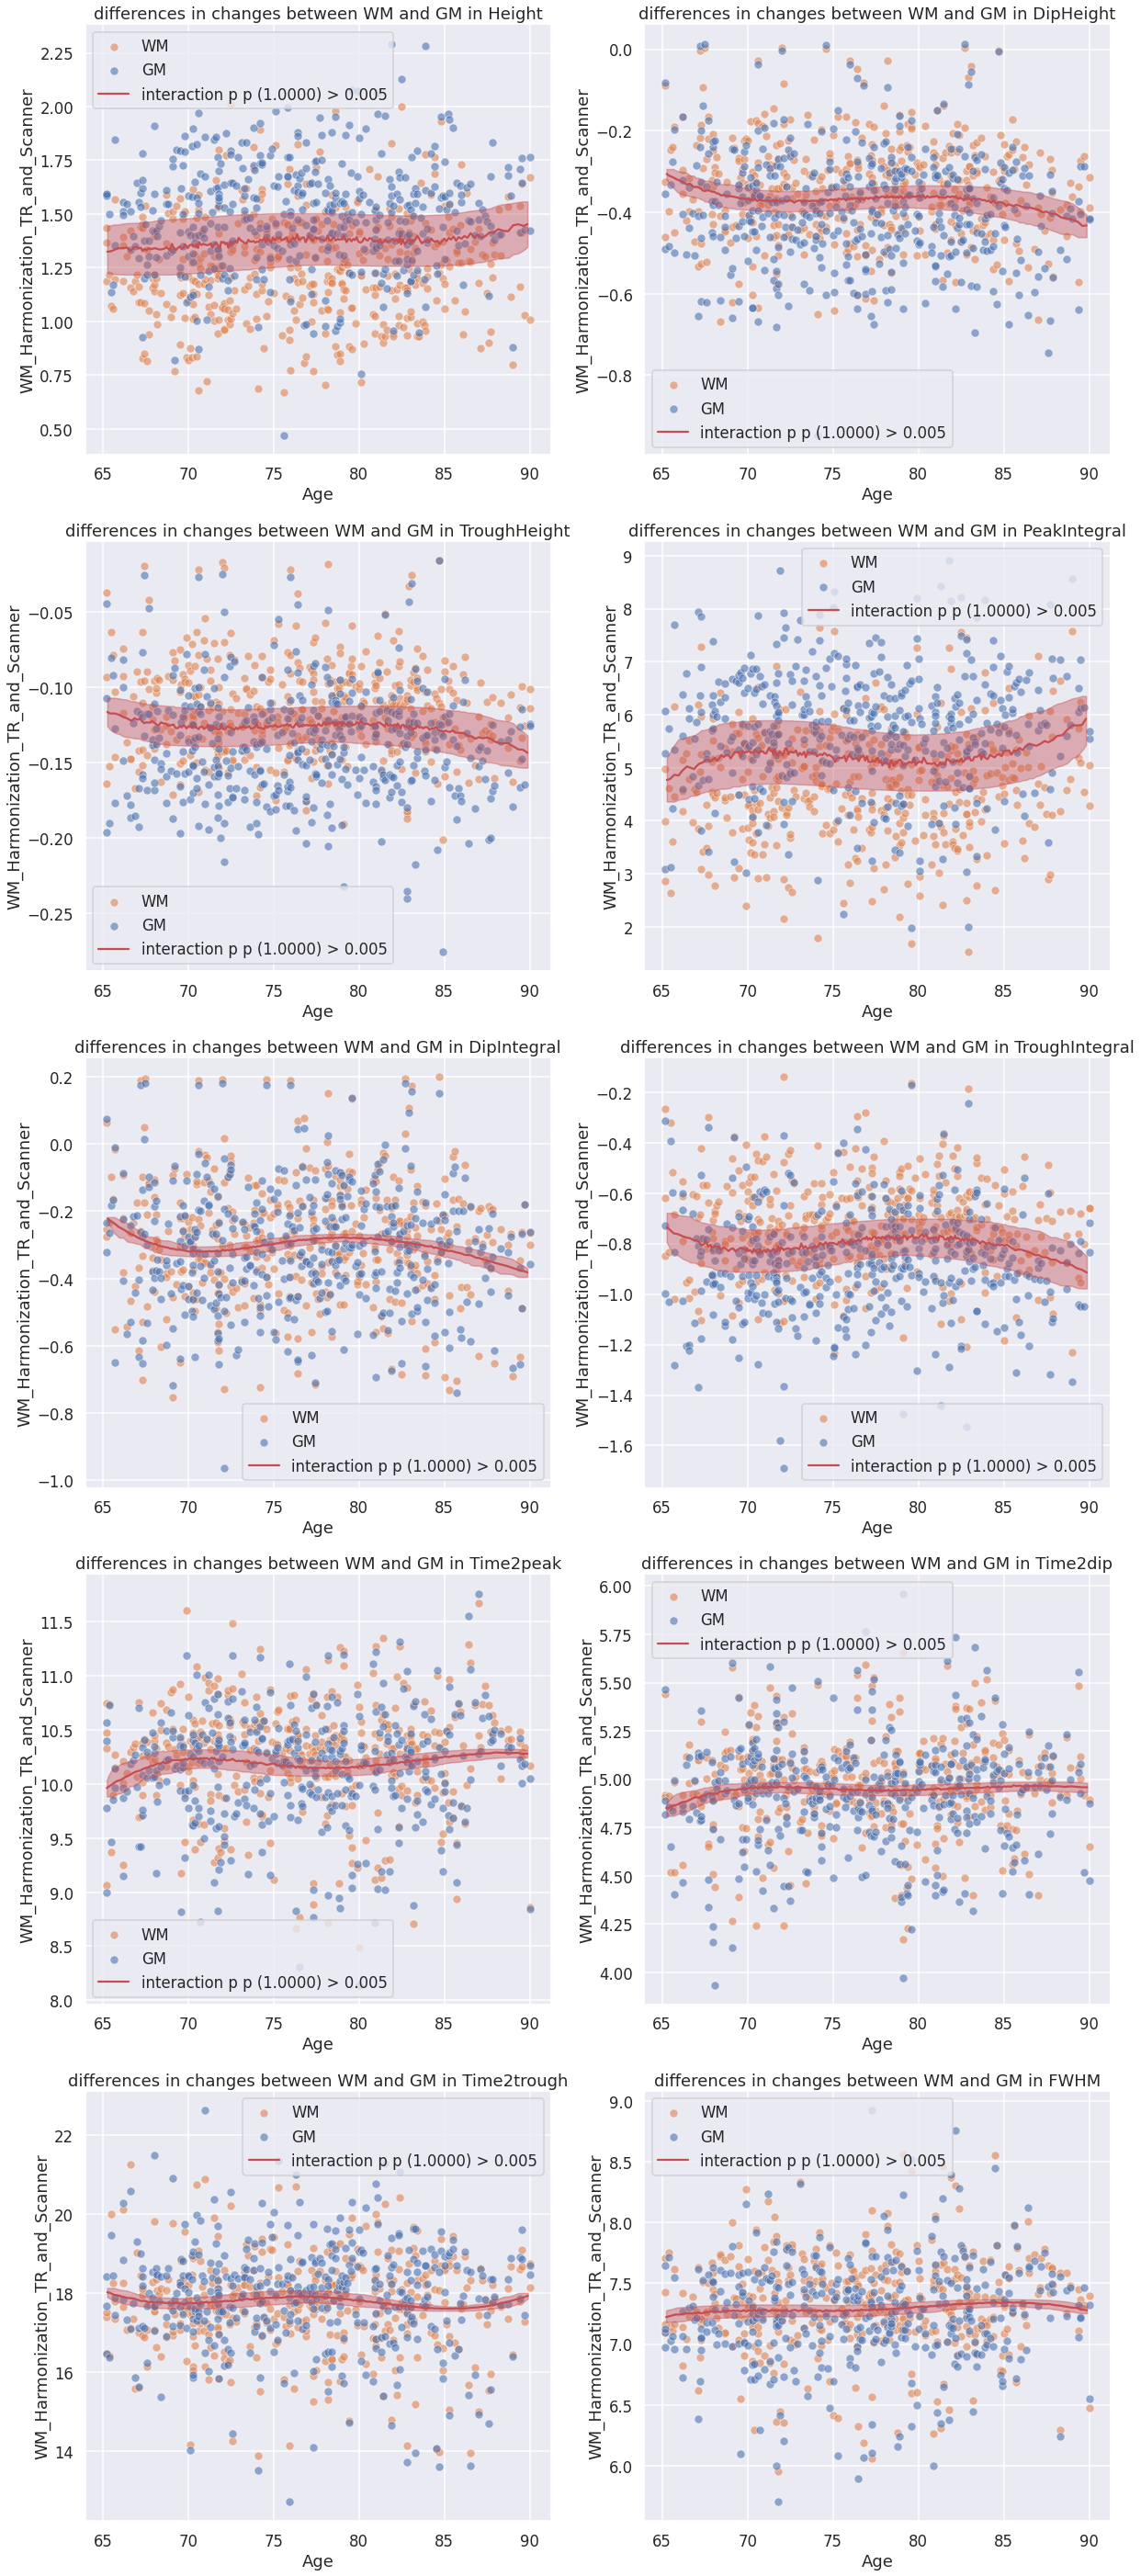

In [233]:
# pal = sns.color_palette() ## 0,1 -- 3,4 -- light-dark
plt.figure(figsize=(20,50))
for i in range(10):
    feature = params[i]
    file = filedir + feature + '.csv'
    df = pd.read_csv(file)
    # df = df.loc[df['TR'] ==0.607]

    df, _ = remove_outlier(df, 'WM_Harmonization_TR_and_Scanner')

    df = df.loc[ (df['Age'] >= 65) & (df['Age'] <= 90) ]
    df = df.loc[df.ResearchGroup =='CN']
    df = df.sort_values('Age')

    plt.subplot(5,2,i+1)
    tit = "differences in changes between WM and GM in {}".format(feature)
    plt.title(tit)
    df_leg = df.copy()

    sns.scatterplot(x = 'Age', y='WM_Harmonization_TR_and_Scanner', data=df_leg, color=pal[1], alpha=0.6, label='WM')
    sns.scatterplot(x = 'Age', y='GM_Harmonization_TR_and_Scanner', data=df_leg, color=pal[0], alpha=0.6, label='GM')

    df = create_indicator(df)

    n = int(len(df)/4)
    m1, m2, res  = model_2(df, 'Age', 'Val_Harmonized', [], knots=77, threshold=0.005)

    name_models = ['interaction', 'without interaction']
    c11, c21, cmean1, x1 = compute_CI(m1,n, "indicator*bs(Age, knots = (77,), degree=3)")
    # c12, c22, cmean2, x2 = compute_CI(m2,n, "indicator+bs(Age, knots = (77,), degree=3)")


    plt.fill_between(x1, c11, c21, color=pal[3], alpha=0.4)
    # plt.fill_between(x2, c12, c22, color=pal[2], alpha=0.4)

    sns.lineplot(x=x1, y=cmean1, label="{} p {}".format(name_models[0], res), color = pal[3])
    # sns.lineplot(x=x2, y=cmean2, label="{} ".format(name_models[1]), color = pal[2])

    plt.xlabel('Age')
    plt.legend()